# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [13]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.871776,1510.436561,-11.564785,0.467857,0.492421,0.039722,-0.024564,3.493947
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.766828,1496.167248,-11.400420,0.468084,0.492194,0.039722,-0.024110,6.932228
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.226230,1503.248120,2.978110,0.487951,0.472327,0.039722,0.015624,0.955843
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.848754,1500.976808,-7.128054,0.473986,0.486292,0.039722,-0.012306,-2.978035
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.493737,1483.488252,7.005485,0.493514,0.466764,0.039722,0.026750,4.315751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2.024111e+10,18.0,Round 18,4.0,Final,1.720278e+09,1.720242e+09,Accor Stadium,Sydney,27223.0,...,60.0,-59.0,1511.360142,1488.692560,22.667582,0.521733,0.450911,0.027356,0.070822,1.936236
1318,2.024111e+10,18.0,Round 18,5.0,Final,1.720287e+09,1.720251e+09,Leichhardt Oval,Sydney,10311.0,...,-6.0,30.0,1457.994294,1528.130944,-70.136650,0.400985,0.591264,0.007752,-0.190279,-8.892546
1319,2.024111e+10,18.0,Round 18,6.0,Final,1.720294e+09,1.720258e+09,Queensland Country Bank Stadium,Townsville,18787.0,...,14.0,-44.0,1502.064761,1506.824271,-4.759509,0.477259,0.483019,0.039722,-0.005761,1.101418
1320,2.024111e+10,18.0,Round 18,7.0,Final,1.720361e+09,1.720325e+09,Allianz Stadium,Sydney,23388.0,...,16.0,18.0,1551.887506,1501.545036,50.342470,0.565786,0.416973,0.017241,0.148813,12.045402


## Modelling
During the modelling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of three distinct models: XGBoost, Random Forest, and Gradient Boosting Classifier. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best model, or `footy_tipper`, is selected based on the superior performance on the chosen optimization metric. Additionally, a `LabelEncoder`(`label_encoder`), used to encode the categorical target variable, is returned. This LabelEncoder is specific to the model that performed best. The selected model, encapsulated in a pipeline with pre-processing steps and hyperparameter tuning, is now ready for the prediction phase.

### Test Modelling Data Preparation

In [3]:
# Set the random seed for reproducibility
random_seed = 42

# Define the test size proportion
test_size = 0.2

# Randomly shuffle the DataFrame and split
training_data = data.sample(frac=1 - test_size, random_state=random_seed)
test_data = data.drop(training_data.index)

### Poisson Modelling

In [4]:
home_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_home',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
home_model


Model training: XGBRegressor
gen	nevals	fitness     	fitness_std	fitness_max	fitness_min 
0  	20    	-1.34122e+11	5.84626e+11	-6.6213    	-2.68245e+12
1  	31    	-7.82351    	0.665032   	-6.95249   	-9.44746    
2  	23    	-7.15172    	0.458987   	-6.51765   	-8.10168    
3  	27    	-6.85541    	0.365078   	-6.44671   	-7.56653    
4  	27    	-6.53814    	0.216272   	-5.71924   	-6.85834    
5  	28    	-6.36219    	0.329585   	-5.69192   	-6.57007    
6  	31    	-6.19561    	0.365063   	-5.69192   	-6.57007    
7  	28    	-5.8946     	0.311288   	-5.69192   	-6.44671    
8  	33    	-5.70908    	0.00989491 	-5.69139   	-5.72468    
9  	30    	-5.70347    	0.00851138 	-5.69139   	-5.71924    
10 	28    	-5.69625    	0.00638811 	-5.68619   	-5.70388    
Best parameters: {'n_estimators': 356, 'learning_rate': 0.028824869610296316, 'max_depth': 2, 'subsample': 0.5621069416661675, 'colsample_bytree': 0.3637276234250554, 'gamma': 0.16409106209020793}
Best score: -5.686189358262344

Best over

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x16a2a1010>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x16a48edd0>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x16a496c10>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x16a7a3f90>},
                            population_size=20, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

In [5]:
away_model = mf.train_and_select_best_model(
    training_data, tc.predictors, 'team_final_score_away',
    tc.use_rfe, tc.num_folds, tc.opt_metric
)
away_model


Model training: XGBRegressor
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	-9.26376	4.73682    	-6.35664   	-28.7411   
1  	28    	-6.90377	0.590005   	-6.32543   	-8.48075   
2  	22    	-6.53128	0.303222   	-6.30002   	-7.59832   
3  	31    	-6.31018	0.0757823  	-6.22517   	-6.57383   
4  	27    	-6.17872	0.145349   	-5.8064    	-6.32543   
5  	23    	-6.13013	0.135644   	-5.8064    	-6.28418   
6  	30    	-5.89917	0.161219   	-5.6945    	-6.19334   
7  	23    	-5.78935	0.0868804  	-5.6945    	-5.98708   
8  	26    	-5.72867	0.0648137  	-5.57373   	-5.82765   
9  	30    	-5.67782	0.0521725  	-5.57373   	-5.79788   
10 	29    	-5.6159 	0.0947848  	-5.37832   	-5.6945    
Best parameters: {'n_estimators': 135, 'learning_rate': 0.08672161806680877, 'max_depth': 3, 'subsample': 0.7498978957249565, 'colsample_bytree': 0.558640662579535, 'gamma': 0.4555152960436946}
Best score: -5.378318614518176

Best overall model: XGBRegressor
Best overall score: -5.378318614518176


Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['round_name', 'venue_name',
                                                   'city', 'team_home',
                                                   'team_away',
                                                   'broadcast_channel1',
                                                   'broadcast_channel2',
                                                   'broadcast_channel3',
                                                   'game_day'])])),
                ('hyperparamtuning',
                 GASearchCV(crossover_probability=0.5,
                            estimator=XGBRe...
                                        'learning_rate': <sklearn_genetic.space.space.Continuous object at 0x17ce5ae50>,
                                        'max_depth': <sklearn_genetic.space.space.Integer object at 0x17ce3fbd0>,
                                        'n_estimators': <sklearn_genetic.space.space.Integer object at 0x17ceb0890>,
                                        'subsample': <sklearn_genetic.space.space.Continuous object at 0x17ce3c250>},
                            population_size=20, return_train_score=True,
                            scoring=make_scorer(mean_poisson_deviance, greater_is_better=False)))])

###  Evaluation
This evaluates the method in the research pipeline. Not to be replicated in the final product.

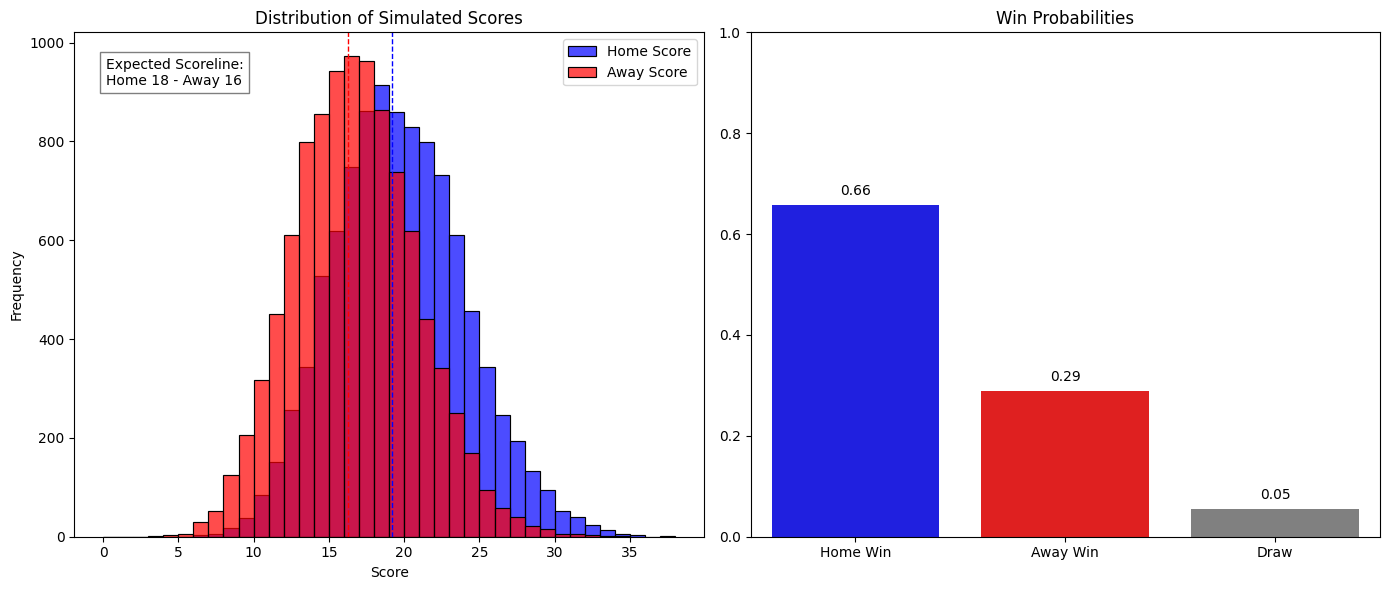

In [26]:
# Example usage with test_data
mp.plot_sampling_distributions(home_model, away_model, test_data, tc.predictors)

Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

    home_win       0.73      0.79      0.76       150
    away_win       0.69      0.62      0.65       114
        draw       0.00      0.00      0.00         0

   micro avg       0.72      0.72      0.72       264
   macro avg       0.47      0.47      0.47       264
weighted avg       0.71      0.72      0.71       264



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_cla

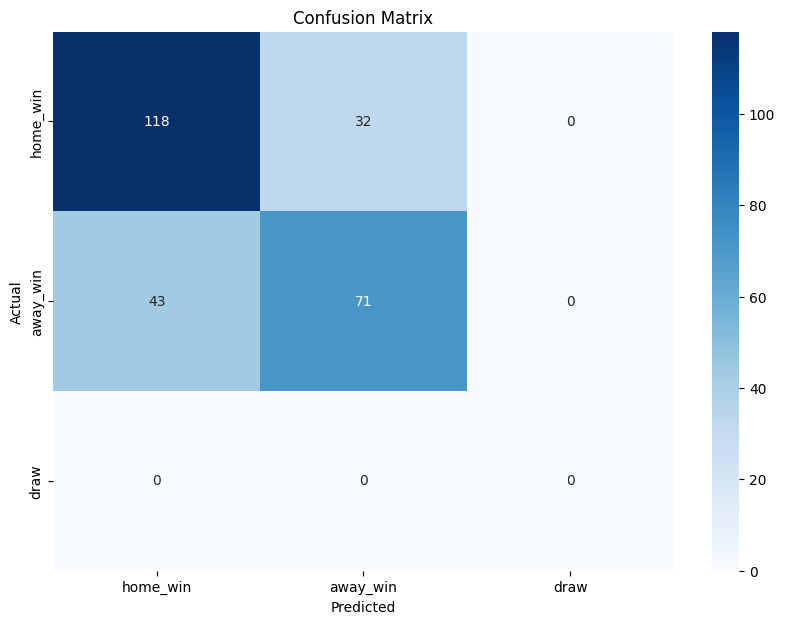

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


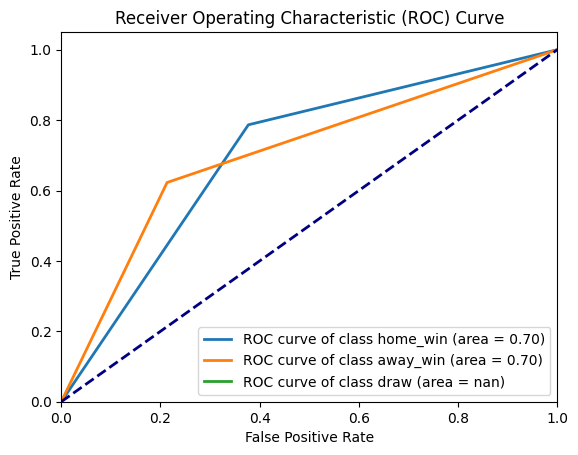

In [6]:
# Evaluate the models on the test data
result_df = mp.evaluate_models(home_model, away_model, test_data, tc.predictors)

#### Feature importance
The `get_feature_importance` function retrieves feature importances from a trained scikit-learn pipeline. It accounts for different transformations, such as one-hot encoding and recursive feature elimination. The function then returns a sorted DataFrame listing each feature alongside its respective importance, aiding in understanding the model's decision-making process.

In [7]:
# feature_importance_df = mp.get_feature_importances_from_pipeline(footy_tipper, tc.predictors)
# feature_importance_df

## Save Models
The `save_models` function stores the trained LabelEncoder and Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [8]:
mf.save_models(home_model, 'home_model', project_root)
mf.save_models(away_model, 'away_model', project_root)

Pipeline saved to models/home_model.pkl
Pipeline saved to models/away_model.pkl


## Predict
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by connecting to the SQLite database and extracting the required data. The trained model and LabelEncoder are then loaded from the disk, and the prediction is performed using the `model_predictions` function. The predictions are stored in the 'predictions' table of the database, allowing for easy retrieval and analysis.

In [9]:
# label_encoder, footy_tipper = pf.load_models(project_root)
home_model = pf.load_models('home_model', project_root)
away_model = pf.load_models('away_model', project_root)

home_model model pipeline loaded
away_model model pipeline loaded


In [10]:
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

Getting inference data...


,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.024111e+10,19.0,Round 19,1.0,Pre Game,1.720727e+09,1.720691e+09,Kayo Stadium,Redcliffe,None,...,-16.0,10.0,1496.657139,1497.037817,-0.380677,0.483310,0.476968,0.039722,0.006342,1.724033
1,2.024111e+10,19.0,Round 19,2.0,Pre Game,1.720814e+09,1.720778e+09,PointsBet Stadium,Sydney,None,...,34.0,-38.0,1508.923252,1459.456087,49.467165,0.558765,0.413879,0.027356,0.144886,8.692100
2,2.024111e+10,19.0,Round 19,3.0,Pre Game,1.720892e+09,1.720856e+09,Cbus Super Stadium,Gold Coast,None,...,8.0,52.0,1495.658494,1467.378022,28.280473,0.529538,0.443106,0.027356,0.086432,4.349967
3,2.024111e+10,19.0,Round 19,4.0,Pre Game,1.720899e+09,1.720863e+09,Suncorp Stadium,Brisbane,None,...,30.0,-38.0,1499.044636,1493.719869,5.324768,0.491193,0.469085,0.039722,0.022107,5.434833
4,2.024111e+10,19.0,Round 19,5.0,Pre Game,1.720973e+09,1.720937e+09,4 Pines Park,Sydney,None,...,-4.0,20.0,1507.051811,1490.883753,16.168058,0.512672,0.459972,0.027356,0.052700,3.792200


In [14]:
import pandas as pd

# Predict match outcomes and scorelines for the inference data
outcomes, margins = pf.predict_match_outcome_and_scoreline(home_model, away_model, inference_data, tc.predictors)
pd.merge(outcomes, margins, on='game_id')


,game_id,home_team_result,home_team_win_prob,home_team_lose_prob,draw_prob,predicted_home_score,predicted_away_score,predicted_margin
0,2.024111e+10,Win,0.4708,0.4628,0.0664,22,22,0
1,2.024111e+10,Win,0.8953,0.0793,0.0254,26,17,9
2,2.024111e+10,Win,0.8651,0.1061,0.0288,25,18,7
3,2.024111e+10,Win,0.4931,0.4468,0.0601,22,22,0
4,2.024111e+10,Win,0.7866,0.1709,0.0425,26,18,8


In [15]:
pf.save_predictions_to_db(
    outcomes, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

Saving predictions to database...


# this is the sending bit

In [16]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

True

In [17]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

,game_id,home_team_result,team_home,position_home,team_head_to_head_odds_home,team_away,position_away,team_head_to_head_odds_away,home_team_win_prob,home_team_lose_prob,round_id,competition_year,round_name
0,20241111910,Win,Dolphins,6,1.68,South Sydney Rabbitohs,13,2.18,0.4708,0.4628,19,2024,Round 19
1,20241111920,Win,Cronulla-Sutherland Sharks,4,1.46,Wests Tigers,17,2.71,0.8953,0.0793,19,2024,Round 19
2,20241111930,Win,Gold Coast Titans,15,1.43,Parramatta Eels,16,2.84,0.8651,0.1061,19,2024,Round 19
3,20241111940,Win,Brisbane Broncos,11,1.47,St. George Illawarra Dragons,10,2.68,0.4931,0.4468,19,2024,Round 19
4,20241111950,Win,Manly-Warringah Sea Eagles,7,1.39,Newcastle Knights,9,3.00,0.7866,0.1709,19,2024,Round 19


In [18]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

,team,price,price_min
1,Cronulla-Sutherland Sharks,1.46,1.116944
2,Gold Coast Titans,1.43,1.155936
4,Manly-Warringah Sea Eagles,1.39,1.271294


In [ ]:
# sf.upload_df_to_drive(
#     predictions, 
#     json_path, 
#     os.getenv('FOLDER_ID'), 
#     "predictions.csv"
# )

In [19]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

Subject: Reg's Predictions for NRL Round 19, Get Your Wallets Ready!

G'day Mates,

I've got another round of diamond-studded predictions for Round 19, served up hot from our machine learning oracle, Footy Tipper. Hold onto your hats because there are some spicy match-ups coming your way!

First up, we got the Dolphins (currently sitting pretty at 6th place) predicted to send the Rabbitohs (struggling at 13th place) back to their bunny burrow. The bookies are showing favor towards the Dolphins with a price of 1.68 (that's for the dolphins wearing pink bikinis, not the aquatic creatures, mind you!).

Moving on, the Sharks, cruising at 4th place, are expected to make sushi out of the Tigers, who are limping their way on 17th place. It's not looking good for our feline friends. The Sharks come with a pretty pleasing price of 1.46.

Riding high on the Footy Tipper's favor are the Titans who, despite their dismal 15th position, are expected to get the better of the Eels who are stuck at 16t

In [ ]:
# sf.send_emails(
#     "footy-tipper-email-list", 
#     f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
#     reg_reagan, 
#     os.getenv('MY_EMAIL'), 
#     os.getenv('EMAIL_PASSWORD'), 
#     json_path
# )